In [2]:
import os
import glob
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import pydicom
import cv2
#from joblib import Parallel, delayed

In [42]:
!ls "/data3/wv2019/data/PLIC_MILANO_DICOM/PLICV4_DISCO4/GEMS_IMG/2013_JUL/05/AB090240/"  

D7594HI0  D7594HQC  D7594HQO  D7594I34	D7594IBG  D7594IBS  D7594IK8
D7594HI2  D7594HQE  D7594HQQ  D7594I36	D7594IBI  D7594IJU  D7594ISA
D7594HI4  D7594HQG  D7594HQS  D7594I38	D7594IBK  D7594IK0  D7594ISC
D7594HQ6  D7594HQI  D7594HQU  D7594I3A	D7594IBM  D7594IK2  D7594ISE
D7594HQ8  D7594HQK  D7594I30  D7594I3C	D7594IBO  D7594IK4  D7594ISG
D7594HQA  D7594HQM  D7594I32  D7594IBE	D7594IBQ  D7594IK6


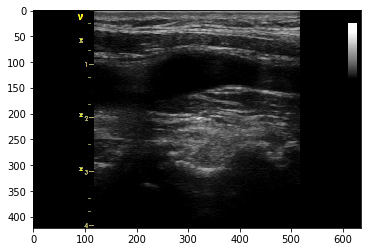

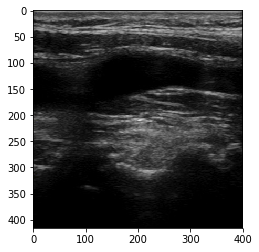

In [7]:
ds = pydicom.dcmread("/data3/wv2019/data/PLIC_MILANO_DICOM/PLICV4_DISCO5/GEMS_IMG/2013_SEP/19/CB084414/D9J8PO2C")
#plt.imshow(file.pixel_array[:,:,:])
plt.imshow(ds.pixel_array)
plt.show()
plt.imshow(metacrop(ds))
plt.show()

In [84]:
#cropping by metadata
#input: img - dcm file
#output: cropped img file
"""def old_metacrop(img):
    print(type(img))
    temp = (img.get_item((0x0018,0x6011)).value)
    print(temp)
    x0 = temp[0x00186018].value
    x1 = temp[0x0018601c].value
    y0 = temp[0x0018601a].value
    y1 = temp[0x0018601e].value
    return img.pixel_array[x0:x1, y0:y1]"""
def metacrop(file):
    for key in file.dir():
        value = getattr(file, key, "")
        if(key == "SequenceOfUltrasoundRegions"):
            value = value[0]
            break
    x0, x1, y0, y1 = None, None, None, None
    for key in value.dir():
        if key == "RegionLocationMinX0":
            x0 = getattr(value, key, "")
        if key == "RegionLocationMaxX1":
            x1 = getattr(value, key, "")
        if key == "RegionLocationMinY0":
            y0 = getattr(value, key, "")
        if key == "RegionLocationMaxY1":
            y1 = getattr(value, key, "")
    return file.pixel_array[y0:y1+1, x0:x1+1]

In [37]:
#cropping by metadata

#input: img - dcm file
#output: cropped pixel array

def metacrop2(file):
  for key in file.dir():
      value = getattr(file, key, "")
      if(type(value) == pydicom.sequence.Sequence and key == "SequenceOfUltrasoundRegions"):
          value = value[0]
          break
  x0, x1, y0, y1 = None, None, None, None
  for key in value.dir():
      if key == "RegionLocationMinX0":
          x0 = getattr(value, key, "")
      if key == "RegionLocationMaxX1":
          x1 = getattr(value, key, "")
      if key == "RegionLocationMinY0":
          y0 = getattr(value, key, "")
      if key == "RegionLocationMaxY1":
          y1 = getattr(value, key, "")

  #return file.pixel_array[y0:y1,x0:x1]
  return x0,x1+1,y0,y1+1

In [8]:
ROOT = "/data3/wv2019/data/PLIC_MILANO_DICOM"
ROOT_OUT = "/data3/wv2019/data/processed/PLIC_MILANO_DICOM"

In [9]:
# define callbacks
def person_names_callback(dataset, data_element):
    if data_element.VR == "PN":
        data_element.value = "anonymous"
        
def curves_callback(dataset, data_element):
    if data_element.tag.group & 0xFF00 == 0x5000:
        del dataset[data_element.tag]

t2tag = 'PatientBirthDate'

In [10]:
### TODO
# - consider also Doppler mode
# - extend to the whole set of images
# - check whether the anonymized DICOM file differs from the original (except for the removed sensitive data)
# - parallelize code

In [ ]:
glob.glob(os.path.join(ROOT, "PLICV*_DISCO*", "GEMS_IMG", "*", "*", "*", "*"))

In [4]:
# directory tree:
# ROOT
# - PLIC<something>_DISCO<N>
#   - GEMS_IMG
#     - <YEAR>_<MONTH>
#       - <NN>
#         - <SOMEDIR>
#           - DICOMs

# organize DICOMs by patient ID
# start with a subset of imgs
for fn in glob.glob(os.path.join(ROOT, "PLICV*_DISCO*", "GEMS_IMG", "*", "*", "*", "*"), recursive=True):
    ds = pydicom.read_file(fn)

    # clear private data
    ds.walk(person_names_callback)
    ds.walk(curves_callback)
    # address/sanitize patient IDs (remove spaces and non-alphanum characters)
    ds.data_element('PatientID').value = re.sub(r'\W+', '', ds.data_element('PatientID').value.strip().replace(" ", "_"))
    # type 2 tags
    if t2tag in ds:
        ds.data_element(t2tag).value = ''

    patientID = ds.PatientID
    dicomName = os.path.basename(fn).strip().replace(" ", "_")

    out_dir = os.path.join(ROOT_OUT, str(patientID))
    os.makedirs(out_dir, exist_ok=True)
    out_dicom = os.path.join(out_dir, f"{dicomName}.dcm")
    #out_png = os.path.join(out_dir, f"conv_{dicomName}.png")
    
    ds.pixel_array = metacrop(ds)
    
    # write DICOM Standard compliant file
    if not os.path.isfile(out_dicom):
        pydicom.filewriter.write_file(out_dicom, ds, write_like_original=False)
    # write PNG for non-doppler images
    # NOTE: not needed at first, let's keep also Doppler mode
    #if len(ds.SequenceOfUltrasoundRegions) == 1 :
    #    if not os.path.isfile(out_png):
    #        cv2.imwrite(out_png, ds.pixel_array)


In [ ]:

print("Original", file.pixel_array.shape)
plt.imshow(file.pixel_array)
plt.show()

ds = pydicom.read_file("/data3/wv2019/data/PLIC_CHIESA_DICOM/PLIC CHIESA IN VALMALENCO_0153")
pdata = metacrop2(ds)
ds.Rows, ds.Columns, _ = pdata.shape
ds.PixelData = pdata.tobytes()
out_dicom = "/data3/wv2019/NEWDICOMTEST.dcm"
pydicom.filewriter.write_file(out_dicom, ds, write_like_original=False)


file = pydicom.dcmread(out_dicom)
print("Original", file.pixel_array.shape)
plt.imshow(file.pixel_array)
plt.show()

ORIGINAL (422, 636, 3)


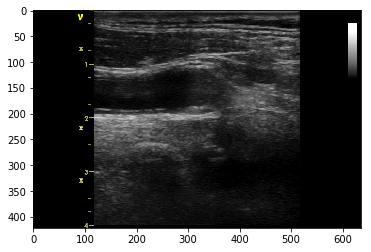

(417, 401, 3)
b'@;%LGAKEGH'


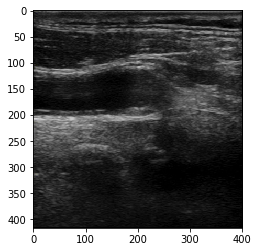

ValueError: With tag (7fe0, 0010) got exception: Pixel Data with undefined length must start with an item tag
Traceback (most recent call last):
  File "/home/webvalley/anaconda3/lib/python3.7/site-packages/pydicom/tag.py", line 30, in tag_in_exception
    yield
  File "/home/webvalley/anaconda3/lib/python3.7/site-packages/pydicom/filewriter.py", line 521, in write_dataset
    write_data_element(fp, dataset.get_item(tag), dataset_encoding)
  File "/home/webvalley/anaconda3/lib/python3.7/site-packages/pydicom/filewriter.py", line 481, in write_data_element
    raise ValueError('Pixel Data with undefined length must '
ValueError: Pixel Data with undefined length must start with an item tag


In [105]:
# directory tree:
# ROOT
# - PLIC<something>_DISCO<N>
#   - GEMS_IMG
#     - <YEAR>_<MONTH>
#       - <NN>
#         - <SOMEDIR>
#           - DICOMs

# organize DICOMs by patient ID
# start with a subset of imgs
for fn in glob.glob(os.path.join(ROOT, "PLICV*_DISCO*", "GEMS_IMG", "*", "*", "*", "*"), recursive=True):
    file = pydicom.dcmread(fn)

    print("ORIGINAL", file.pixel_array.shape)
    plt.imshow(file.pixel_array)
    plt.show()
    
    ds = pydicom.read_file(fn)
    
    # clear private data
    ds.walk(person_names_callback)
    ds.walk(curves_callback)
    # address/sanitize patient IDs (remove spaces and non-alphanum characters)
    ds.data_element('PatientID').value = re.sub(r'\W+', '', ds.data_element('PatientID').value.strip().replace(" ", "_"))
    # type 2 tags
    if t2tag in ds:
        ds.data_element(t2tag).value = ''

    patientID = ds.PatientID
    dicomName = os.path.basename(fn).strip().replace(" ", "_")

    out_dir = os.path.join(ROOT_OUT, str(patientID))
    os.makedirs(out_dir, exist_ok=True)
    out_dicom = os.path.join(out_dir, f"{dicomName}.dcm")
    #out_png = os.path.join(out_dir, f"conv_{dicomName}.png")

    
    pdata = metacrop(ds)
    print(pdata.shape)
    print(pdata.tobytes()[:10])
    plt.imshow(pdata)
    plt.show()
    ds.PixelData = pdata.tobytes()
    ds.Rows, ds.Columns, _ = pdata.shape
    #ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    #ds.is_little_endian = True
    #ds.is_implicit_VR = False
    ds.PixelData = pdata.tostring()
    ds.PlanarConfiguration = 0
    #print(pdata)
    #ds.pixel_array.shape = ds.pixel_array.reshape(pdata.shape[0], pdata.shape[1])
    
    #ds.save_as(out_dicom)
    pydicom.filewriter.write_file(out_dicom, ds, write_like_original=False)

    

    file = pydicom.dcmread(out_dicom)
    print("NEW", file.pixel_array.shape)
    plt.imshow(file.pixel_array)
    plt.show()

    
    #plt.imshow(ds.pixel_array)
    #plt.show()
    #x0,x1,y0,y1 = metacrop(ds)
    #print(type(ds.pixel_array))
    #ds.pixel_array = img.reshape([img.shape[1], img.shape[2], 3])
    
    #plt.imshow(ds.pixel_array[y0:y1, x0:x1])
    #plt.show()
    
    # write DICOM Standard compliant file
    #if not os.path.isfile(out_dicom):
    #    pydicom.filewriter.write_file(out_dicom, ds, write_like_original=False)
    # write PNG for non-doppler images
    # NOTE: not needed at first, let's keep also Doppler mode
    #if len(ds.SequenceOfUltrasoundRegions) == 1 :
    #    if not os.path.isfile(out_png):
    #        cv2.imwrite(out_png, ds.pixel_array)
    break

(122, 150, 3)
b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


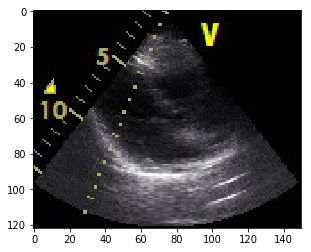

Expected Item with tag (fffe, e000) at data position 0x0
Expected Item with tag (fffe, e000) at data position 0x8


NotImplementedError: None

In [100]:
filename1 = "/data3/wv2019/data/PLIC_MILANO_DICOM/PLICV4_DISCO8/GEMS_IMG/2014_FEB/03/DF171059/E248TJ80"
filename2 = "/data3/wv2019/data/processedTEST/test"
out_dicom = "/data3/wv2019/data/processedTEST/done.dcm"



ds1 = pydicom.read_file(filename1)
    
# clear private data
ds1.walk(person_names_callback)
ds1.walk(curves_callback)
# address/sanitize patient IDs (remove spaces and non-alphanum characters)
ds1.data_element('PatientID').value = re.sub(r'\W+', '', ds1.data_element('PatientID').value.strip().replace(" ", "_"))
# type 2 tags
if t2tag in ds1:
    ds1.data_element(t2tag).value = ''

patientID = ds1.PatientID
dicomName = os.path.basename(fn).strip().replace(" ", "_")

out_dir = os.path.join(ROOT_OUT, str(patientID))
os.makedirs(out_dir, exist_ok=True)
out_dicom = os.path.join(out_dir, f"{dicomName}.dcm")
#out_png = os.path.join(out_dir, f"conv_{dicomName}.png")

    
pdata = metacrop(ds1)
print(pdata.shape)
print(pdata.tobytes()[:10])
plt.imshow(pdata)
plt.show()
ds1.PixelData = pdata.tobytes()
ds1.Rows, ds1.Columns, _ = pdata.shape
plt.imshow(ds1.pixel_array)
plt.show()
    #print(pdata)
    #ds.pixel_array.shape = ds.pixel_array.reshape(pdata.shape[0], pdata.shape[1])
    
    #ds.save_as(out_dicom)
    
ds2.PixelData = ds1.pixel_array.tobytes()
ds2.Rows, ds2.Columns, _ = ds1.pixel_array.shape
pydicom.filewriter.write_file(out_dicom, ds2, write_like_original=False)

    

In [77]:
ds = pydicom.dcmread("/data3/wv2019/data/processed/PLIC_MILANO_DICOM/PLIC1471/D7IABA5U.dcm")
plt.imshow(ds.pixel_array)
plt.show()

error: unpack requires a buffer of 4 bytes